In [1]:
# built in
import json
import random
import os
# append to path to allow relative imports
import sys
sys.path.append("..")

# 3rd party
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich.console import Console
from rich.progress import track
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from transformers import BertForTokenClassification, BertModel, AdamW, BertTokenizerFast
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# own
from utils.data.preproc import Pipeline, PipelineConfigs
from utils.data.parse import ParseUtils
from utils.data.parse import ParseUtils
from utils.generic import timer

# Prep Data

In [13]:
data_path = os.path.join(
    os.path.abspath('../../'), # Root of project
    'data/coleridgeinitiative-show-us-the-data/' # Data folder
)

configs = PipelineConfigs(
    DATA_PATH = data_path,
    MAX_LENGTH = 64,
    OVERLAP = 20,
    MAX_SAMPLE = None,
    SAVE = True,
    EXTRACTED_FILENAME = 'train_ner.data',
    TOKENIZED_FILENAME = 'train_ner.data.tokenized',
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
if n_gpu > 0: 
    torch.cuda.get_device_name(0)
    print('Running on GPU')

In [3]:
pipeline = Pipeline(configs)

In [4]:
input_ids, tags, attention_masks = pipeline.load_outputs()

In [5]:
# Intermezzo fix tag labels
tag2id = {t:i for i, t in enumerate(np.unique(tags))}
tags = [[tag2id[tag] for tag in sent] for sent in tags]

In [6]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(
    input_ids, 
    tags,
    random_state=2018, 
    test_size=0.1
)

tr_masks, val_masks, _, _ = train_test_split(
    attention_masks, 
    input_ids,
    random_state=2018, 
    test_size=0.1
)

In [7]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [8]:
BATCH_SIZE = 32

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(
    valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

---

# Using `BertModel` to feed embeddings into separate classifier

In [9]:
# Get bert model. This will output raw hidden states
model = BertModel.from_pretrained(
    'bert-base-cased',
    num_labels = 3
)

In [10]:
# Create one layer linear classifier to be used on top
# of hidden states
cls = nn.Linear(model.config.hidden_size, model.config.num_labels)

In [11]:
def create_batched_embeddings(
    model,  # The HuggingFace BertModel to create the embeddings
    inputs, # The inputs to be fed to the model
    masks,  # Attention masks for the inputs (same shape as inputs)
    batch_size:int=32,
):
    """
    Feed batches of size `batch_size` into the provided model from provided inputs and masks,
    and return the resulting embeddings as a `torch.tensor`
    """
    total = inputs.shape[0]
    # Drop the last data points if they don't fit with the batch size
    total = (total // batch_size) * batch_size
    
    return [ 
        model(tr_inputs[i:i+batch_size], attention_mask=tr_masks[i:i+batch_size])
            .last_hidden_state
            .detach()
        
            for i in track(range(0, total, batch_size),
               description='Creating embeddings')
    ]

def create_batched_tensor(
    tensor,
    batch_size:int=32,
):
    """
    From any given tensor, split the first dimension into batches of size
    `batch_size` and return as a `torch.tensor`
    """
    total = tensor.shape[0] 
    # Drop the last data points if they don't fit with the batch size
    total = (total // batch_size) * batch_size
    
    return torch.tensor([
        tensor[i:i+batch_size].numpy()
        for i in track(range(0, total, batch_size),
            description='Creating batches')
    ])

In [ ]:
emb_data = create_batched_embeddings(model, tr_inputs, tr_masks, batch_size=BATCH_SIZE)

In [ ]:
labels = create_batched_tensor(tr_tags, batch_size=BATCH_SIZE)
masks = create_batched_tensor(tr_masks, batch_size=BATCH_SIZE)

In [159]:
emb_data.shape, labels.shape, masks.shape

torch.Size([169, 32, 64, 768])

In [206]:
NUM_LABELS = model.config.num_labels
EPOCHS = 200
LEARNING_RATE = 3e-5

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(cls.parameters(), lr=LEARNING_RATE)

In [207]:
loss_values, accuracies, f1_scores = [], [], []

In [208]:
total = emb_data.shape[0]

USE_MASK = True

for epoch in range(1,EPOCHS+1):
    
    # Collect metrics for all batches
    losses, accs, f1s = [], [], []
    
    for step, (X, y) in enumerate(zip(emb_data, labels)):
                
        # Compute prediction
        logits = cls(X)
        # Flatten over batch and sequence
        flat_logits = logits.view(-1, NUM_LABELS)
        
        # Compute loss
        if USE_MASK:
            loss_mask = masks[step].view(-1) == 1
            flat_y = torch.where(
                loss_mask, y.view(-1), torch.tensor(loss_fn.ignore_index).type_as(y)
            )
            loss = loss_fn(flat_logits, flat_y)
        else:
            flat_y = y.view(-1)
            loss = loss_fn(flat_logits, flat_y) 

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # Detach and argmax
        flat_logits = np.argmax(flat_logits.detach(), axis=1)
        flat_y = flat_y.detach()
        
        # Compute metrics
        losses.append(loss.item())        
        accs.append(accuracy_score(flat_logits, flat_y))
        f1s.append(f1_score(flat_logits, flat_y, average='weighted'))
        
    loss = np.mean(losses)
    acc = np.mean(accs)
    f1 = np.mean(f1s)
        
    loss_values.append(loss)
    accuracies.append(acc)
    f1_scores.append(f1)
    
    if epoch % 50 == 0:
        print('[ Epoch {:3}/{} ]   Loss: {:.5f}   Acc: {:.5f}   F1: {:.5f}'.format(epoch, EPOCHS, loss, acc, f1))

[ Epoch  50/1000 ]   Loss: 0.07105   Acc: 0.48149   F1: 0.64907
[ Epoch 100/1000 ]   Loss: 0.06106   Acc: 0.48149   F1: 0.64908
[ Epoch 150/1000 ]   Loss: 0.05734   Acc: 0.48149   F1: 0.64908
[ Epoch 200/1000 ]   Loss: 0.05479   Acc: 0.48149   F1: 0.64908
[ Epoch 250/1000 ]   Loss: 0.05262   Acc: 0.48149   F1: 0.64908
[ Epoch 300/1000 ]   Loss: 0.05064   Acc: 0.48149   F1: 0.64907
[ Epoch 350/1000 ]   Loss: 0.04880   Acc: 0.48149   F1: 0.64907
[ Epoch 400/1000 ]   Loss: 0.04707   Acc: 0.48149   F1: 0.64907
[ Epoch 450/1000 ]   Loss: 0.04543   Acc: 0.48149   F1: 0.64906
[ Epoch 500/1000 ]   Loss: 0.04389   Acc: 0.48149   F1: 0.64906
[ Epoch 550/1000 ]   Loss: 0.04244   Acc: 0.48149   F1: 0.64905
[ Epoch 600/1000 ]   Loss: 0.04107   Acc: 0.48149   F1: 0.64905
[ Epoch 650/1000 ]   Loss: 0.03979   Acc: 0.48149   F1: 0.64904
[ Epoch 700/1000 ]   Loss: 0.03859   Acc: 0.48148   F1: 0.64902
[ Epoch 750/1000 ]   Loss: 0.03747   Acc: 0.48147   F1: 0.64901
[ Epoch 800/1000 ]   Loss: 0.03643   Acc

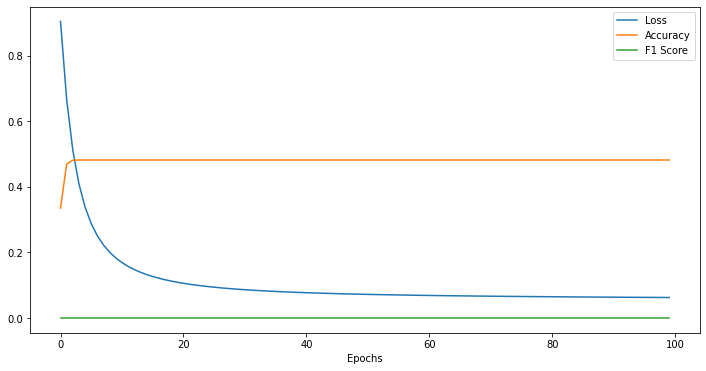

In [196]:
plt.figure(figsize=(12,6))
plt.xlabel('Epochs')
plt.plot(loss_values, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.legend()
plt.show()

---

# Using `BertForTokenClassification` with possible finetuning

In [9]:
model = BertForTokenClassification.from_pretrained(
    'bert-base-cased',
    num_labels = 3, # Hardcode for now
    output_attentions=False,
    output_hidden_states=False,
)

In [11]:
# Models are initialized in eval mode by default. We can call model.train() to put it in train mode.
#model.train()

In [12]:
# Full finetuning to tune all model parameters
# Otherwise, only train classifier
FULL_FINETUNING = True

if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [13]:
EPOCHS = 4
LEARNING_RATE = 3e-5
EPSILON = 1e-8

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=LEARNING_RATE,
    eps=EPSILON
)

In [19]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [20]:
from transformers import get_linear_schedule_with_warmup

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [21]:
from seqeval.metrics import f1_score, accuracy_score

In [22]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
n_train_samples = len(train_dataloader)
n_val_samples = len(valid_dataloader)

for eidx in range(EPOCHS):

    print(f'Epoch {eidx}/{EPOCHS}')

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):

        print(f'Step {step}/{n_train_samples}')

        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:

        print(f'Step {step}/{n_val_samples}')

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch 0/4
Step 0/15792
Step 1/15792
Step 2/15792
Step 3/15792
Step 4/15792
Step 5/15792
Step 6/15792
Step 7/15792
Step 8/15792
Step 9/15792
Step 10/15792
Step 11/15792
Step 12/15792


KeyboardInterrupt: 

In [23]:
outputs = model(tr_inputs[:32], attention_mask=tr_masks[:32], labels=tr_tags[:32])

In [ ]:
loss = outputs.loss
loss.backward()
optimizer.step()

In [27]:
outputs.logits.size()

torch.Size([32, 64, 3])